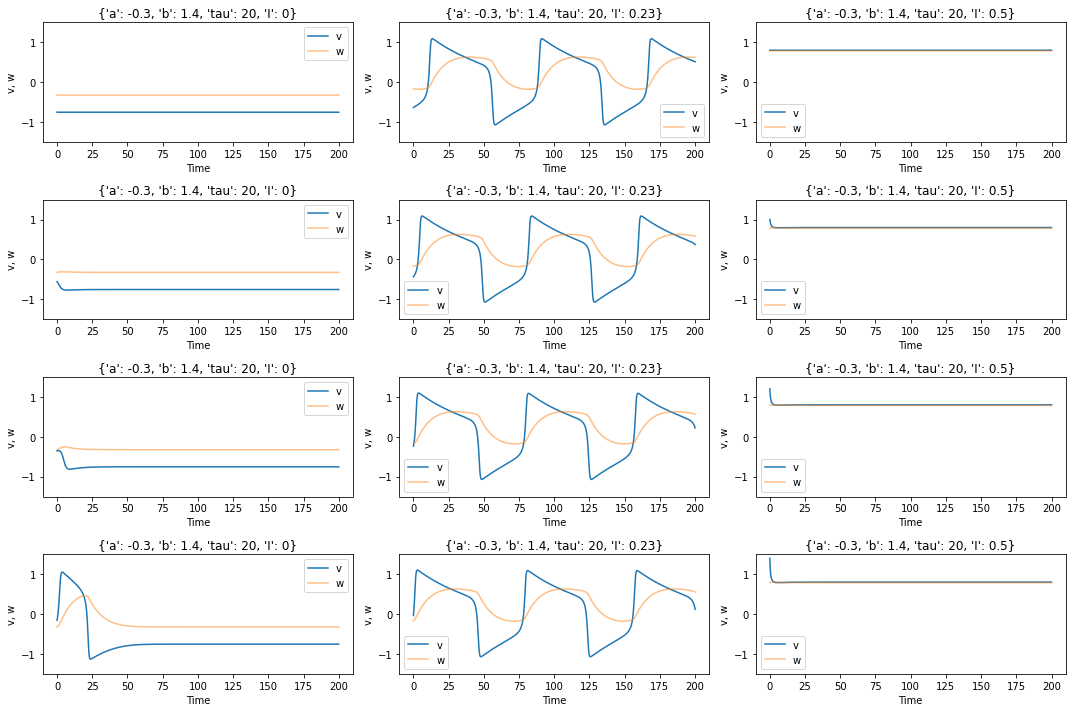

In [18]:
#https://www.normalesup.org/~doulcier/teaching/modeling/excitable_systems.html
scenarios = [
     {"a":-.3, "b":1.4, "tau":20, "I":0},
     {"a":-.3, "b":1.4, "tau":20, "I":0.23},
     {"a":-.3, "b":1.4, "tau":20, "I":0.5}
]
time_span = np.linspace(0, 200, num=1500)
def fitzhugh_nagumo(x, t, a, b, tau, I):
    """Time derivative of the Fitzhugh-Nagumo neural model.
    Args:
       x (array size 2): [Membrane potential, Recovery variable]
       a, b (float): Parameters.
       tau (float): Time scale.
       t (float): Time (Not used: autonomous system)
       I (float): Constant stimulus current. 
    Return: dx/dt (array size 2)
    """
    return np.array([x[0] - x[0]**3 - x[1] + I, 
                     (x[0] - a - b * x[1])/tau])

def get_displacement(param, dmax=0.3,time_span=np.linspace(0,200, 1000), number=20):
    # We start from the resting point...
    ic = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                      y0=[0,0],
                                                      t= np.linspace(0,999, 1000))[-1]
    # and do some displacement of the potential. 
    traj = [] 
    for displacement in np.linspace(0,dmax, number):
        traj.append(scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                      y0=ic+np.array([displacement,0]),
                                                      t=time_span))
    return traj

# Do the numerical integration.
trajectories = {} # We store the trajectories in a dictionnary, it is easier to recover them. 
for i,param in enumerate(scenarios):
    trajectories[i] = get_displacement(param, number=4, time_span=time_span, dmax=0.6)

# Draw the trajectories. 
fig, ax = plt.subplots(4, len(scenarios), figsize=(5*len(scenarios),2*5))
for i,param in enumerate(scenarios):
        for j in range(len(trajectories[i])):
            ax[j,i].set(xlabel='Time', ylabel='v, w',ylim=[-1.5,1.5],
                     title='{}'.format(param))
            v = ax[j,i].plot(time_span,trajectories[i][j][:,0], color='C0')
            w = ax[j,i].plot(time_span,trajectories[i][j][:,1], color='C1', alpha=.5)
            ax[j,i].legend([v[0],w[0]],['v','w'])
plt.tight_layout()


In [1]:
    
def jacobian_fitznagumo(v, w, a, b, tau, I):
    """ Jacobian matrix of the ODE system modeling Fitzhugh-Nagumo's excitable system
    Args
    ====
        v (float): Membrane potential
        w (float): Recovery variable
        a,b (float): Parameters
        tau (float): Recovery timescale.
    Return: np.array 2x2"""
    return np.array([[- 3 * v**2 + 1 , -1],
                       [1/tau, -b/tau]])
def stability(jacobian):
    """ Stability of the equilibrium given its associated 2x2 jacobian matrix. 
    Use the eigenvalues. 
    Args:
        jacobian (np.array 2x2): the jacobian matrix at the equilibrium point.
    Return:
        (string) status of equilibrium point.
    """
    
    eigv = np.linalg.eigvals(jacobian)
    
    
    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        nature = "Center" 
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        nature = "Saddle"
    else: 
        stability = 'Unstable' if all(np.real(eigv)>0) else 'Stable'
        nature = stability + (' focus' if all(np.imag(eigv)!=0) else ' node')
    return nature

scenarios = [
     {"a":-.3, "b":1.4, "tau":20, "I":0},
     {"a":-.3, "b":1.4, "tau":20, "I":0.23},
     {"a":-.3, "b":1.4, "tau":20, "I":0.5}
]

# initialize state
def step_perturb(N,c0,c1,start,end):
    result = np.full((N,),c0,dtype=float)
    result[start:end] = c1
    print(np.unique(result,return_counts=True))
    return result


import tifffile
        
def nullcline(a,b,I):
    fig,axes = plt.subplots(1,1,figsize=(8,6))
    u = np.linspace(-1,1,100)
    axes.plot(u,-u**3+u+I,color='k',ls=':')
    axes.plot(u,(u-a)/b,color='k')
    axes.set(xlim=[-1,1],ylim=[-1,1])
    


[0.05 0.1  0.15 0.2  0.25 0.3 ]


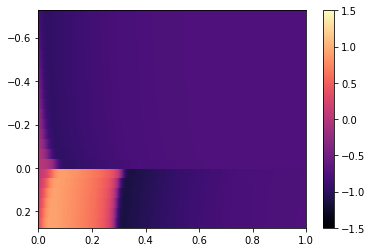

In [2]:


def no_diffusion():
    para_reaction = scenarios[0]
    u0,v0 = find_roots(**para_reaction)[0]
    U0 = np.flip(np.arange(0.3,u0,-0.05))
    N = len(U0)

    storage = MemoryStorage()
    eq = FitzhughNagumoPDE(**para_reaction,**{"d0":0, "d1":0})
    state = eq.get_initial_state(UnitGrid((N,),periodic=True), U0, 0)
    eq.solve(state, t_range=60, tracker=storage.tracker(0.05))
    im = np.stack(storage.data,2)[0]
    u_pulsatile = U0[(im.max(-1)-U0)>0]
    print(u_pulsatile)
    plt.imshow(im,vmin=-1.5,vmax=1.5,extent=[0,1,U0[-1]-0.05/2,U0[0]+0.05/2],cmap="magma",interpolation='nearest',aspect='auto')
    plt.colorbar()
no_diffusion()

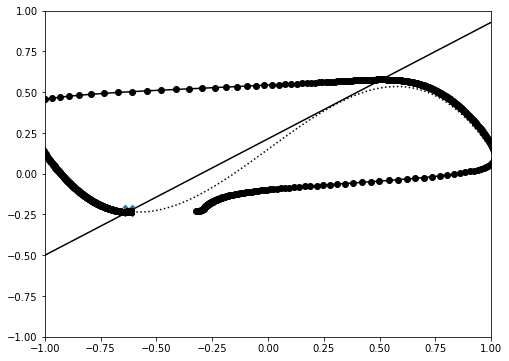

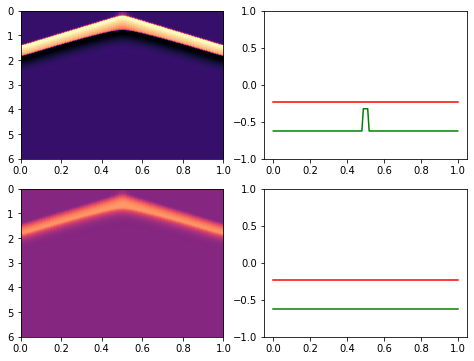

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pde import FieldCollection, PlotTracker, ScalarField, UnitGrid, CartesianGrid, MemoryStorage, PDEBase

def step_perturb(N,d,start,end):
    result = np.zeros((N,),dtype=float)
    result[start:end] = d
    return result


import tifffile
    


def find_roots(a,b,I):
    # The coeficients of the polynomial equation are:
    # 1           * v**3 
    # 0           * v**2 
    # - (1/b - 1) * v**1 
    # - (a/b + I) * v**0
    coef = [1, 0, 1/b - 1, - a/b - I]
    
    # We are only interested in real roots.
    # np.isreal(x) returns True only if x is real. 
    # The following line filter the list returned by np.roots
    # and only keep the real values. 
    roots = [np.real(r) for r in np.roots(coef) if np.isreal(r)]
    
    # We store the position of the equilibrium. 
    return [[r, r - r**3 + I] for r in roots]

    
class FitzhughNagumoPDE(PDEBase):
    def __init__(self, a, b, tau, I, d0, d1):
        self.a = a
        self.b = b
        self.tau = tau
        self.I = I
        self.d0 = d0  # spatial mobility
        self.d1 = d1  # spatial mobility
        self.bc = "natural"  # boundary condition: vanishing derivative for non-periodic axis
        
    def get_initial_state(self, N, u0, v0, perturb_amp=0.5, dx=2, react=True):
        """prepare a useful initial state"""
        self.react = react
        grid = UnitGrid((N,),periodic=True)
        cx = int(N/2)
        perturb = ScalarField(grid, step_perturb(N,perturb_amp,cx-dx,cx+dx), label="Field $perturb$")
        u = ScalarField(grid, u0+perturb, label="Field $u$")
        v = ScalarField(grid, v0, label="Field $v$")
        return FieldCollection([u, v])


    def evolution_rate(self, state, t=0):
        """pure python implementation of the PDE"""
        u, v = state
        rhs = state.copy()
        
        rhs[0] = self.d0 * u.laplace(self.bc)
        rhs[1] = self.d1 * v.laplace(self.bc)
        if self.react:
            rhs[0] += u-u**3-v + self.I
            rhs[1] += (u-self.a-self.b*v)/self.tau
        return rhs



def nullcline(a,b,I):
    fig,axes = plt.subplots(1,1,figsize=(8,6))
    u = np.linspace(-1,1,100)
    axes.plot(u,-u**3+u+I,color='k',ls=':')
    axes.plot(u,(u-a)/b,color='k')
    axes.set(xlim=[-1,1],ylim=[-1,1])
    roots = find_roots(a,b,I)
    for x,y in roots:
        axes.plot(x,y,'x',ms=10,mew=4)
    return roots,axes
    
def plot(storage):
    fig,axes = plt.subplots(2,2,figsize=(8,6),sharey='col')
    stacked = np.stack(storage.data,1)
    for j,color in enumerate(['green','red']):
        axes[j,0].imshow(stacked[j],vmin=-1,vmax=1,extent=[0,1,6,0],cmap="magma",interpolation='nearest',aspect='auto')
        axes[0,1].plot(np.linspace(0,1,stacked.shape[2]),stacked[j,0,:],color=color)
        axes[1,1].plot(np.linspace(0,1,stacked.shape[2]),stacked[j,-1,:],color=color)
    axes[0,1].set(ylim=[-1,1])


def run(params, du, root, tmax=100, N=128):
    u0,v0 = root
    storage = MemoryStorage()
    eq = FitzhughNagumoPDE(**params)
    state = eq.get_initial_state(N, u0, v0, perturb_amp=0.3, react=True)
    eq.solve(state, t_range=tmax, tracker=storage.tracker(0.1))
    return storage
x = 64

params = {"a":-.3, "b":1.4, "I":0.15, "tau":20, "d0":1, "d1":1/10}
roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
sim = run(params, du=0., root=roots[0], tmax=300)
plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,x],stacked[1,:,x],'-ko')


                    

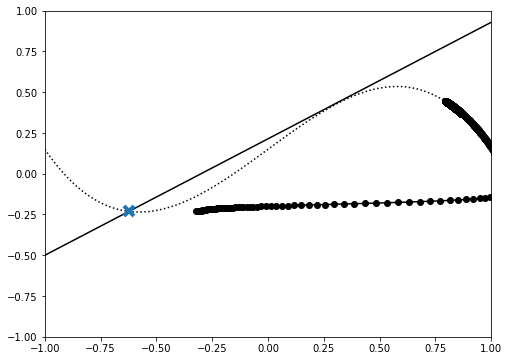

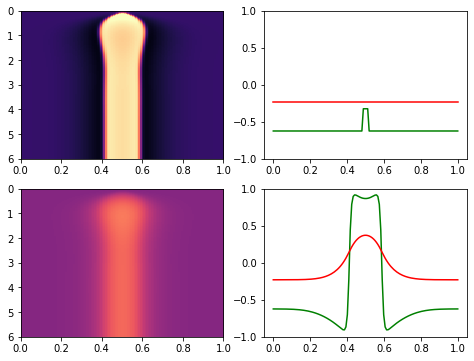

In [2]:
params = {"a":-.3, "b":1.4, "I":0.15, "tau":20, "d0":1, "d1":10}
roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
sim = run(params, du=0., root=roots[0], tmax=300)
plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,x],stacked[1,:,x],'-ko')




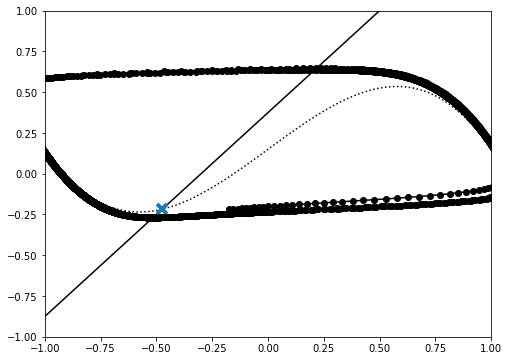

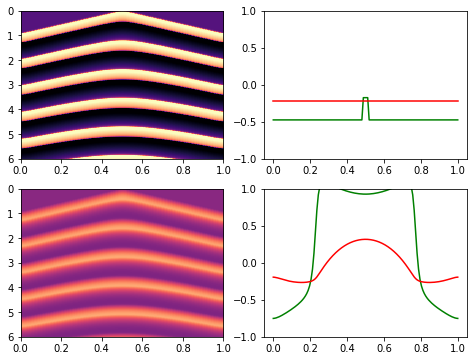

In [17]:
params = {"a":-.3, "b":0.8, "I":0.15, "tau":20, "d0":1, "d1":0.1}
roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
sim = run(params, du=0., root=roots[0], tmax=300)
plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,x],stacked[1,:,x],'-ko')




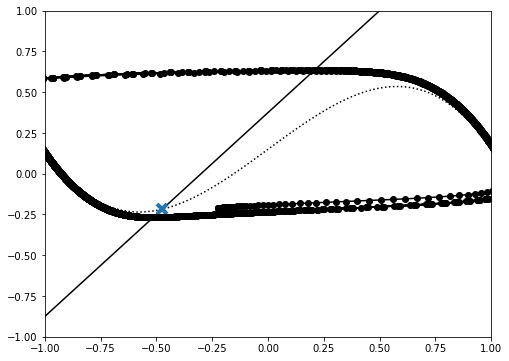

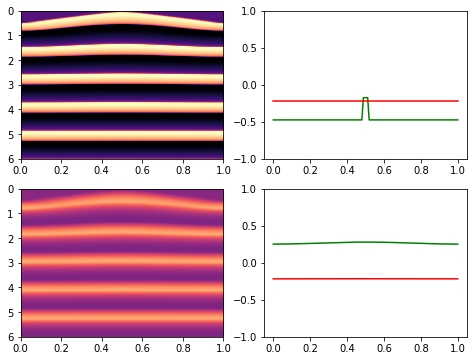

In [5]:
params = {"a":-.3, "b":0.8, "I":0.15, "tau":20, "d0":1, "d1":10}
roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
sim = run(params, du=0., root=roots[0], tmax=300)
plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,x],stacked[1,:,x],'-ko')


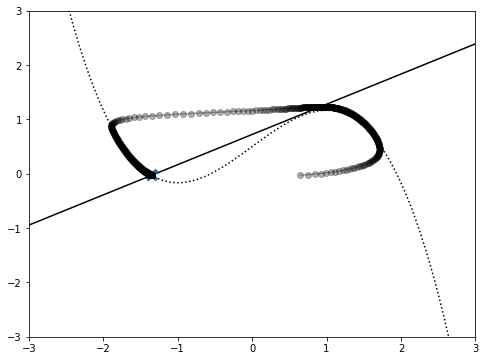

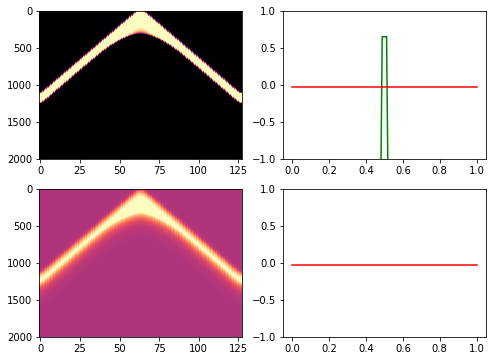

In [96]:

params = {"a":1.3, "b":1.8, "I":0.5, "tau":20, "d0":1, "d1":0.10}

N=128
N2 = int(N/2)

roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
u0,v0 = roots[0]
#'''
sim = MemoryStorage()
eq = FitzhughNagumoPDE(**params)
state = eq.get_initial_state(N, u0, v0, perturb_amp=2, react=True)
eq.solve(state, t_range=200, tracker=sim.tracker(0.1))

plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,N2],stacked[1,:,N2],'-ko',alpha=0.3)
#'''


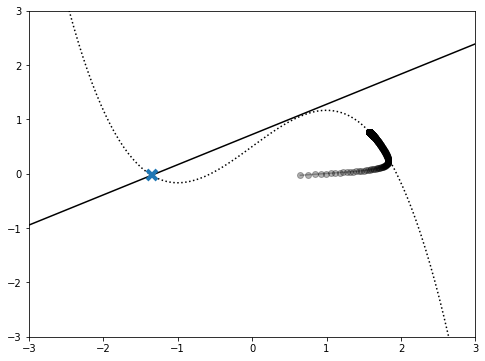

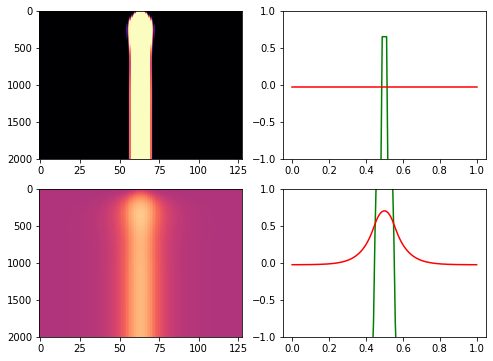

In [97]:
params = {"a":1.3, "b":1.8, "I":0.5, "tau":20, "d0":1, "d1":10}

N=128
N2 = int(N/2)

roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
u0,v0 = roots[0]
#'''
sim = MemoryStorage()
eq = FitzhughNagumoPDE(**params)
state = eq.get_initial_state(N, u0, v0, perturb_amp=2, react=True)
eq.solve(state, t_range=200, tracker=sim.tracker(0.1))

plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,N2],stacked[1,:,N2],'-ko',alpha=0.3)
#'''


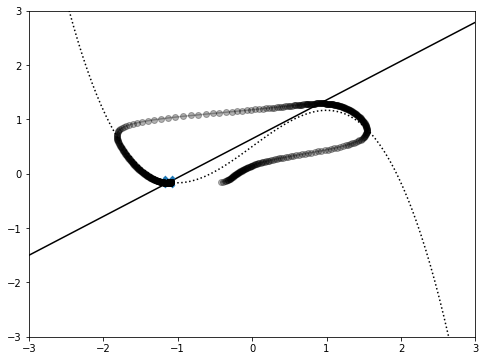

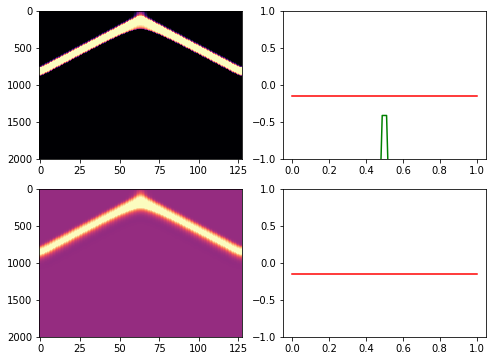

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from pde import FieldCollection, PlotTracker, ScalarField, UnitGrid, CartesianGrid, MemoryStorage, PDEBase

def step_perturb(N,d,start,end):
    result = np.zeros((N,),dtype=float)
    result[start:end] = d
    return result


import tifffile
    


def find_roots(a,b,I):
    # The coeficients of the polynomial equation are:
    # 1           * v**3 
    # 0           * v**2 
    # - (1/b - 1) * v**1 
    # - (a/b + I) * v**0
    coef = [1/3, 0, 1/b - 1, a/b - I]
    
    # We are only interested in real roots.
    # np.isreal(x) returns True only if x is real. 
    # The following line filter the list returned by np.roots
    # and only keep the real values. 
    roots = [np.real(r) for r in np.roots(coef) if np.isreal(r)]
    
    # We store the position of the equilibrium. 
    return [[r, (r+a)/b] for r in roots]

    
class FitzhughNagumoPDE(PDEBase):
    def __init__(self, a, b, tau, I, d0, d1):
        self.a = a
        self.b = b
        self.tau = tau
        self.I = I
        self.d0 = d0  # spatial mobility
        self.d1 = d1  # spatial mobility
        self.bc = "natural"  # boundary condition: vanishing derivative for non-periodic axis
        
    def get_initial_state(self, N, u0, v0, perturb_amp=0.5, dx=2, react=True):
        """prepare a useful initial state"""
        self.react = react
        grid = UnitGrid((N,),periodic=True)
        cx = int(N/2)
        perturb = ScalarField(grid, step_perturb(N,perturb_amp,cx-dx,cx+dx), label="Field $perturb$")
        u = ScalarField(grid, u0+perturb, label="Field $u$")
        v = ScalarField(grid, v0, label="Field $v$")
        return FieldCollection([u, v])


    def evolution_rate(self, state, t=0):
        """pure python implementation of the PDE"""
        u, v = state
        rhs = state.copy()
        
        rhs[0] = self.d0 * u.laplace(self.bc)
        rhs[1] = self.d1 * v.laplace(self.bc)
        if self.react:
            rhs[0] += u-(u**3)/3-v + self.I
            rhs[1] += (u+self.a-self.b*v)/self.tau
        return rhs



def nullcline(a,b,I):
    fig,axes = plt.subplots(1,1,figsize=(8,6))
    u = np.linspace(-3,3,100)
    axes.plot(u,u-(u**3)/3+I,color='k',ls=':')
    axes.plot(u,(u+a)/b,color='k')
    axes.set(xlim=[-3,3],ylim=[-3,3])
    roots = find_roots(a,b,I)
    for x,y in roots:
        axes.plot(x,y,'x',ms=10,mew=4)
    return roots,axes
    
def plot(storage):
    fig,axes = plt.subplots(2,2,figsize=(8,6),sharey='col')
    stacked = np.stack(storage.data,1)
    for j,color in enumerate(['green','red']):
        axes[j,0].imshow(stacked[j],vmin=-1,vmax=1,cmap="magma",interpolation='nearest',aspect='auto')
        axes[0,1].plot(np.linspace(0,1,stacked.shape[2]),stacked[j,0,:],color=color)
        axes[1,1].plot(np.linspace(0,1,stacked.shape[2]),stacked[j,-1,:],color=color)
    axes[0,1].set(ylim=[-1,1])


def run(params, du, root, tmax=100, N=128):
    u0,v0 = root
    storage = MemoryStorage()
    eq = FitzhughNagumoPDE(**params)
    state = eq.get_initial_state(N, u0, v0, perturb_amp=0.3, react=True)
    eq.solve(state, t_range=tmax, tracker=storage.tracker(0.1))
    return storage



params = {"a":0.9, "b":1.4, "I":0.5, "tau":10, "d0":1, "d1":0.10}

N=128
N2 = int(N/2)

roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
u0,v0 = roots[0]

#'''
sim = MemoryStorage()
eq = FitzhughNagumoPDE(**params)
state = eq.get_initial_state(N, u0, v0, perturb_amp=0.7, react=True)
eq.solve(state, t_range=200, tracker=sim.tracker(0.1))

plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,N2],stacked[1,:,N2],'-ko',alpha=0.3)
#'''



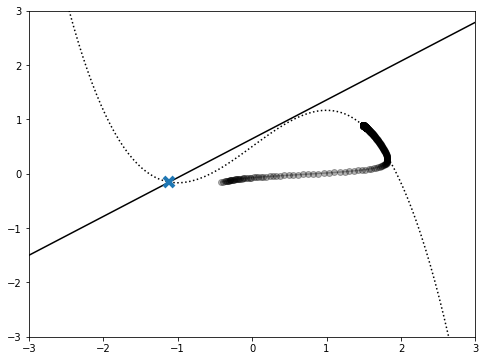

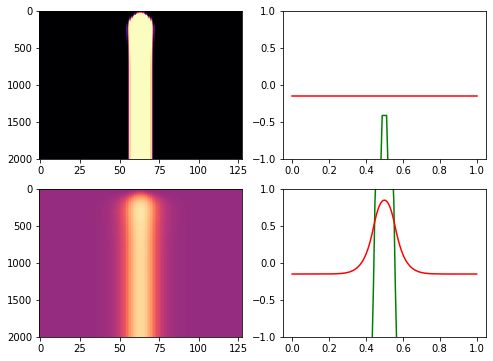

In [99]:
params = {"a":0.9, "b":1.4, "I":0.5, "tau":10, "d0":1, "d1":10}

N=128
N2 = int(N/2)

roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
u0,v0 = roots[0]

#'''
sim = MemoryStorage()
eq = FitzhughNagumoPDE(**params)
state = eq.get_initial_state(N, u0, v0, perturb_amp=0.7, react=True)
eq.solve(state, t_range=200, tracker=sim.tracker(0.1))

plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,N2],stacked[1,:,N2],'-ko',alpha=0.3)
#'''



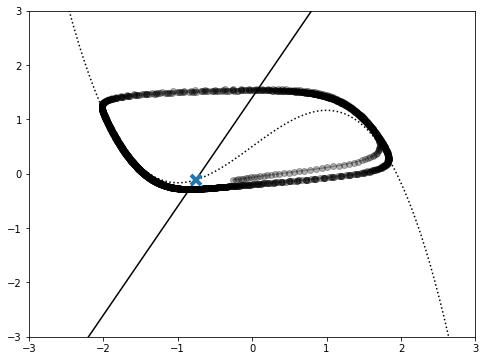

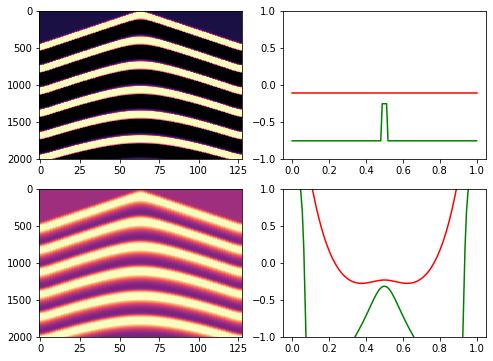

In [121]:
params = {"a":0.9, "b":0.6, "I":0.5, "tau":10, "d0":1, "d1":0.1}

N=128
N2 = int(N/2)

roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
u0,v0 = roots[0]

sim = MemoryStorage()
eq = FitzhughNagumoPDE(**params)
state = eq.get_initial_state(N, u0, v0, perturb_amp=0.5, react=True)
eq.solve(state, t_range=200, tracker=sim.tracker(0.1))

plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,N2],stacked[1,:,N2],'-ko',alpha=0.3)



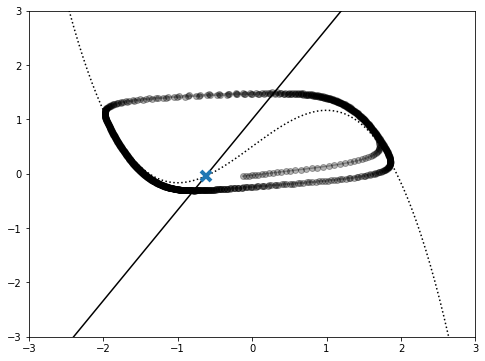

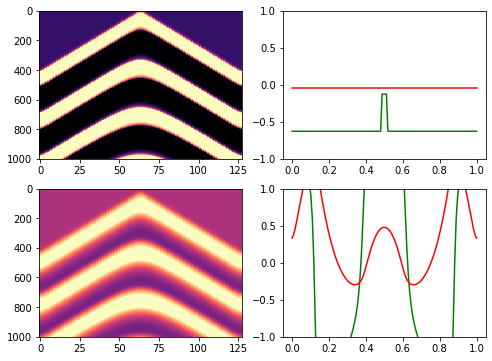

In [132]:


params = {"a":0.6, "b":0.6, "I":0.5, "tau":10, "d0":1, "d1":0.1}

N=128
N2 = int(N/2)

roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
u0,v0 = roots[0]

#'''
sim = MemoryStorage()
eq = FitzhughNagumoPDE(**params)
state = eq.get_initial_state(N, u0, v0, perturb_amp=0.5, react=True)
eq.solve(state, t_range=100, tracker=sim.tracker(0.1))

plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,N2],stacked[1,:,N2],'-ko',alpha=0.3)
#'''

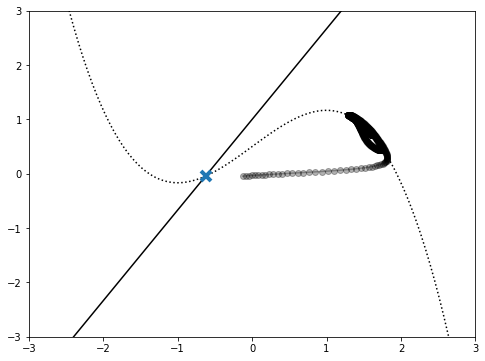

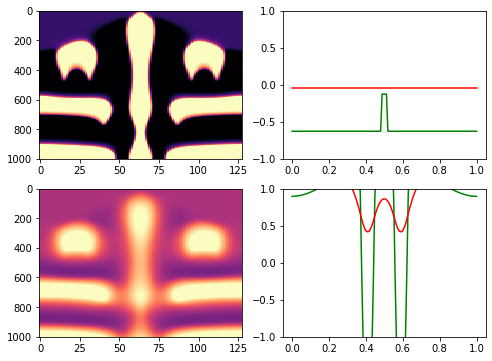

In [133]:


params = {"a":0.6, "b":0.6, "I":0.5, "tau":10, "d0":1, "d1":10}

N=128
N2 = int(N/2)

roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
u0,v0 = roots[0]

#'''
sim = MemoryStorage()
eq = FitzhughNagumoPDE(**params)
state = eq.get_initial_state(N, u0, v0, perturb_amp=0.5, react=True)
eq.solve(state, t_range=100, tracker=sim.tracker(0.1))

plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,N2],stacked[1,:,N2],'-ko',alpha=0.3)
#'''

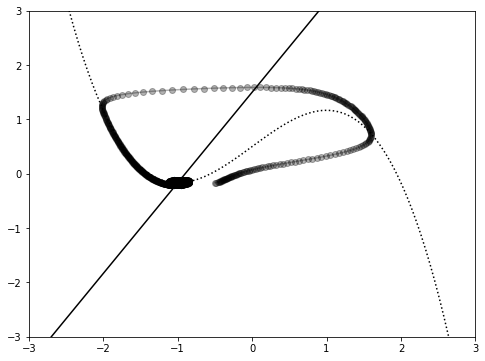

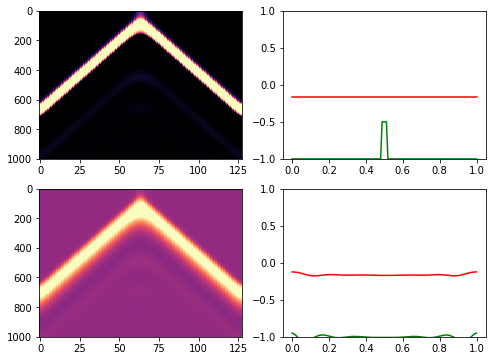

In [124]:
params = {"a":0.9, "b":0.6, "I":0.5, "tau":10, "d0":1, "d1":0.1}

N=128
N2 = int(N/2)

roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
u0,v0 = roots[0]

#'''
sim = MemoryStorage()
eq = FitzhughNagumoPDE(**params)
state = eq.get_initial_state(N, u0, v0, perturb_amp=0.5, react=True)
eq.solve(state, t_range=100, tracker=sim.tracker(0.1))

plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,N2],stacked[1,:,N2],'-ko',alpha=0.3)
#'''

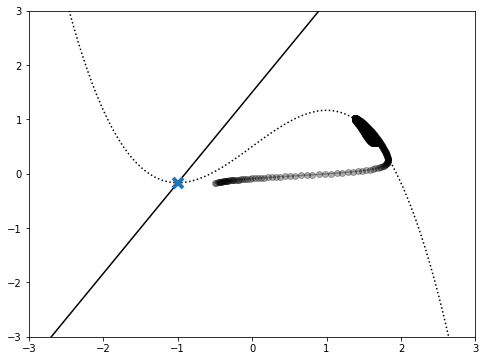

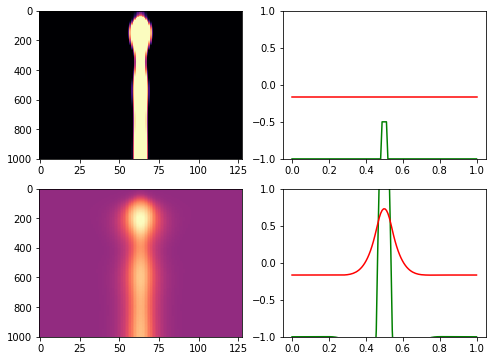

In [131]:
params = {"a":0.9, "b":0.6, "I":0.5, "tau":10, "d0":1, "d1":10}

N=128
N2 = int(N/2)

roots,axes = nullcline(**{name:params[name] for name in ["a","b","I"]})
u0,v0 = roots[0]

#'''
sim = MemoryStorage()
eq = FitzhughNagumoPDE(**params)
state = eq.get_initial_state(N, u0, v0, perturb_amp=0.5, react=True)
eq.solve(state, t_range=100, tracker=sim.tracker(0.1))

plot(sim)
stacked = np.stack(sim.data,1)
axes.plot(stacked[0,:,N2],stacked[1,:,N2],'-ko',alpha=0.3)
#'''

In [134]:
stacked.shape

(2, 1001, 128)

(array([-0.47400387, -0.17400387]), array([124,   4]))
(array([-0.47400387, -0.17400387]), array([124,   4]))


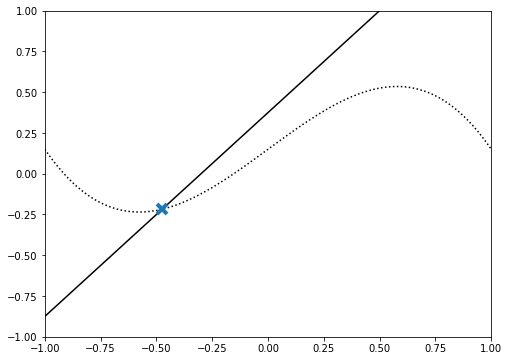

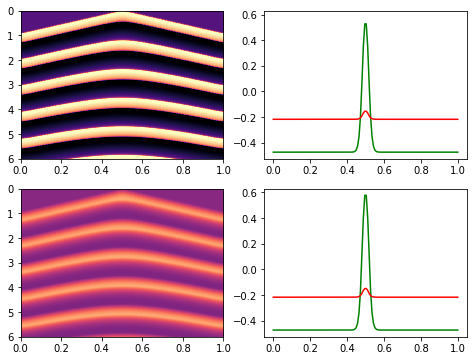

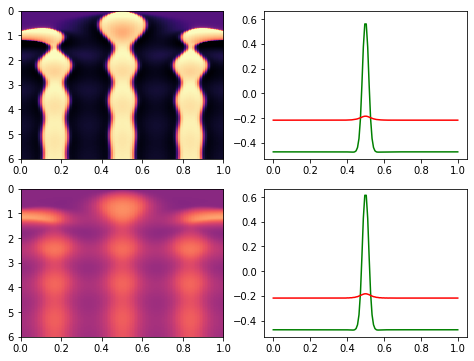

In [3]:
params = {"a":-.3, "b":0.8, "I":0.15, "tau":20, "d0":1, "d1":0.1}
roots = nullcline(**{name:params[name] for name in ["a","b",'I']})
sim = run(params, du=0.3, root=roots[0], tmax=300)
plot(sim)
params = {"a":-.3, "b":0.8, "I":0.15, "tau":20, "d0":1, "d1":10}
sim = run(params, du=0.3, root=roots[0], tmax=300)
plot(sim)


[[0.5601499772018519, 0.6143928408584656], [-0.5045483455831287, -0.14610596113080618], [-0.05560163161872317, 0.17457026312948348]] ['Stable focus', 'Unstable focus', 'Saddle']


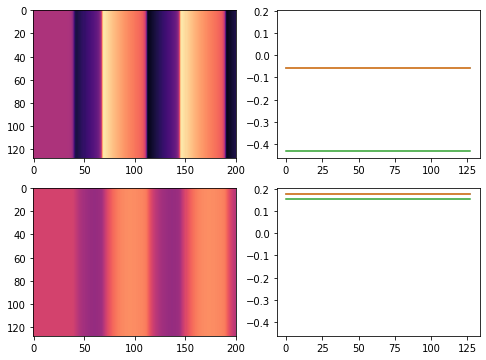

In [4]:
def run():
    para_reaction = {"a":-.3, "b":1.4, "tau":20, "I":0.23}
    roots = find_roots(**para_reaction)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **para_reaction)) for e in roots] 
    print(roots,eqstability)

    u0,v0 = roots[-1]
    N = 128
    #U0 = step_perturb_center(N,u0,u0+0.14,20,30)
    storage = MemoryStorage()
    eq = FitzhughNagumoPDE(**para_reaction,**{"d0":1, "d1":0.00001})
    state = eq.get_initial_state(UnitGrid((N,),periodic=True), u0, v0)
    eq.solve(state, t_range=200, tracker=storage.tracker(1))
    plot(storage)
    
run()

[[0.5601499772018519, 0.6143928408584656], [-0.5045483455831287, -0.14610596113080618], [-0.05560163161872317, 0.17457026312948348]] ['Stable focus', 'Unstable focus', 'Saddle']


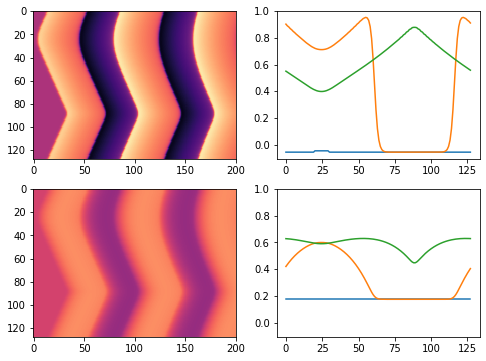

In [9]:
def run():
    para_reaction = {"a":-.3, "b":1.4, "tau":20, "I":0.23}
    roots = find_roots(**para_reaction)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **para_reaction)) for e in roots] 
    print(roots,eqstability)

    u0,v0 = roots[-1]
    N = 128
    U0 = step_perturb_center(N,u0,u0+0.01,20,30)
    storage = MemoryStorage()
    eq = FitzhughNagumoPDE(**para_reaction,**{"d0":1, "d1":0.00001})
    state = eq.get_initial_state(UnitGrid((N,),periodic=True), U0, v0)
    eq.solve(state, t_range=200, tracker=storage.tracker(1))
    plot(storage)
    
run()

[[-0.5866494359232288, -0.2047495970880206], [0.4594455029721114, 0.5424610735515081], [0.12720393295111748, 0.30514566639365537]] ['Stable focus', 'Unstable focus', 'Saddle']


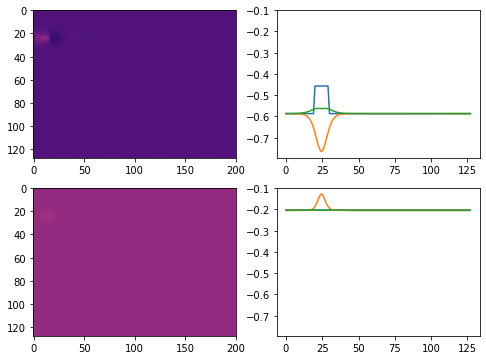

In [10]:
def run():
    para_reaction = {"a":-.3, "b":1.4, "tau":20, "I":0.18}
    roots = find_roots(**para_reaction)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **para_reaction)) for e in roots] 
    print(roots,eqstability)

    u0,v0 = roots[0]
    N = 128
    U0 = step_perturb_center(N,u0,u0+0.13,20,30)#0.13->0.14
    storage = MemoryStorage()
    eq = FitzhughNagumoPDE(**para_reaction,**{"d0":1, "d1":0.00001})
    state = eq.get_initial_state(UnitGrid((N,),periodic=True), U0, v0)
    eq.solve(state, t_range=200, tracker=storage.tracker(1))
    plot(storage)
    
run()

[[-0.5866494359232288, -0.2047495970880206], [0.4594455029721114, 0.5424610735515081], [0.12720393295111748, 0.30514566639365537]] ['Stable focus', 'Unstable focus', 'Saddle']


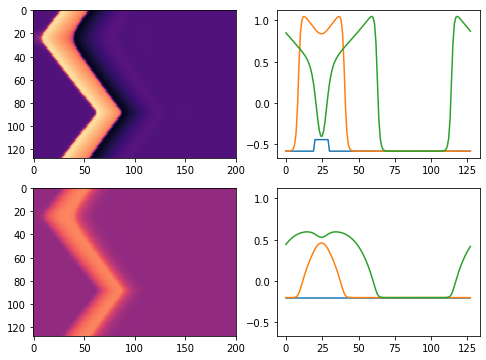

In [11]:
def run():
    para_reaction = {"a":-.3, "b":1.4, "tau":20, "I":0.18}
    roots = find_roots(**para_reaction)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **para_reaction)) for e in roots] 
    print(roots,eqstability)

    u0,v0 = roots[0]
    N = 128
    U0 = step_perturb_center(N,u0,u0+0.14,20,30)#0.13->0.14
    storage = MemoryStorage()
    eq = FitzhughNagumoPDE(**para_reaction,**{"d0":1, "d1":0.00001})
    state = eq.get_initial_state(UnitGrid((N,),periodic=True), U0, v0)
    eq.solve(state, t_range=200, tracker=storage.tracker(1))
    plot(storage)
    
run()

[[-0.6554162893772255, -0.25386877812658976]] ['Stable focus']


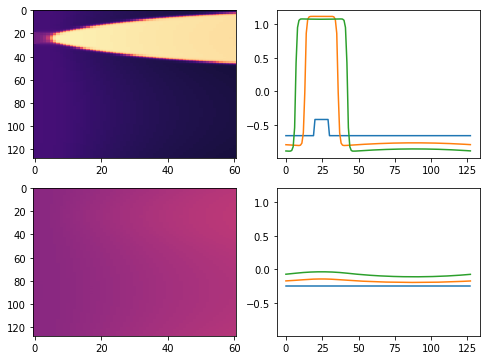

In [91]:
def run():
    para_reaction = {"a":-.3, "b":1.4, "tau":20, "I":0.12}
    roots = find_roots(**para_reaction)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **para_reaction)) for e in roots] 
    print(roots,eqstability)

    u0,v0 = roots[0]
    N = 128
    U0 = step_perturb_center(N,u0,u0+0.24,20,30)#0.13->0.14
    storage = MemoryStorage()
    eq = FitzhughNagumoPDE(**para_reaction,**{"d0":0.5, "d1":500})
    state = eq.get_initial_state(UnitGrid((N,),periodic=True), U0, v0)
    eq.solve(state, t_range=60, tracker=storage.tracker(1))
    plot(storage)
    
run()

[[-0.6554162893772255, -0.25386877812658976]] ['Stable focus']


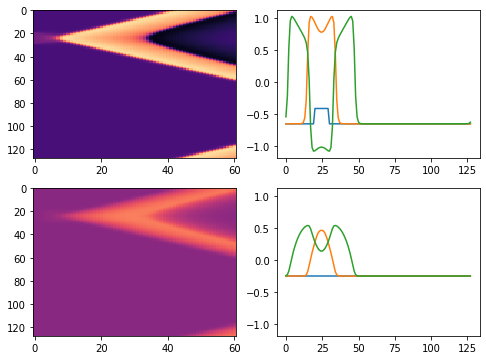

In [89]:
def run():
    para_reaction = {"a":-.3, "b":1.4, "tau":20, "I":0.12}
    roots = find_roots(**para_reaction)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **para_reaction)) for e in roots] 
    print(roots,eqstability)

    u0,v0 = roots[0]
    N = 128
    U0 = step_perturb_center(N,u0,u0+0.24,20,30)#0.13->0.14
    storage = MemoryStorage()
    eq = FitzhughNagumoPDE(**para_reaction,**{"d0":0.5, "d1":0.005})
    state = eq.get_initial_state(UnitGrid((N,),periodic=True), U0, v0)
    eq.solve(state, t_range=60, tracker=storage.tracker(1))
    plot(storage)
    
run()